In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from fibrosisanalysis.parsers.stats_loader import StatsLoader


path = '/Users/arstanbek/Projects/fibrosis-workspace/fibrosisanalysis/examples/data'

hearts = ['E10615_MYH7', 'E10621_ABCC9', 'E10691_RBM20', 'E10788_LMNA',
          'E10884', 'E10927_MYBPC3', 'E11442_TTN', 'E11443_LMNA',
          'E11444_LMNA', 'E11971_MYH7']


stats_loader = StatsLoader()
data = stats_loader.load_hearts_stats(path, hearts)

1/10:   0%|          | 0/19 [00:00<?, ?it/s]

10/10: 100%|██████████| 16/16 [00:00<00:00, 26.54it/s]


In [3]:
area_min = 100
area_max = 200
# position = 5

ddf = data.copy()
ddf = data[['area', 'minor_axis_length', 'major_axis_length', 'image', 
           'distance', 'orientation', 'tangent']]
ddf = ddf[ddf['area'].between(area_min, area_max)]
ddf['minor_axis_length'] = np.where(ddf['minor_axis_length'] == 0, 
                                   0.5, ddf['minor_axis_length'])
ddf['major_axis_length'] = np.where(ddf['major_axis_length'] == 0, 
                                   0.5, ddf['major_axis_length'])

ddf['position'] = np.digitize(ddf['distance'], np.linspace(0, 1.001, 10))

ddf['axis_ratio'] = ddf['major_axis_length'] / ddf['minor_axis_length']

ddf['theta'] = np.arcsin(np.sin(ddf['tangent'] - ddf['orientation']))
ddf['theta_x'] = ddf['axis_ratio'] * np.cos(ddf['theta'])
ddf['theta_y'] = ddf['axis_ratio'] * np.sin(ddf['theta'])

ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63886 entries, 39 to 6408516
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               63886 non-null  int64  
 1   minor_axis_length  63886 non-null  float64
 2   major_axis_length  63886 non-null  float64
 3   image              63886 non-null  object 
 4   distance           63886 non-null  float64
 5   orientation        63886 non-null  float64
 6   tangent            63886 non-null  float64
 7   position           63886 non-null  int64  
 8   axis_ratio         63886 non-null  float64
 9   theta              63886 non-null  float64
 10  theta_x            63886 non-null  float64
 11  theta_y            63886 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 6.3+ MB


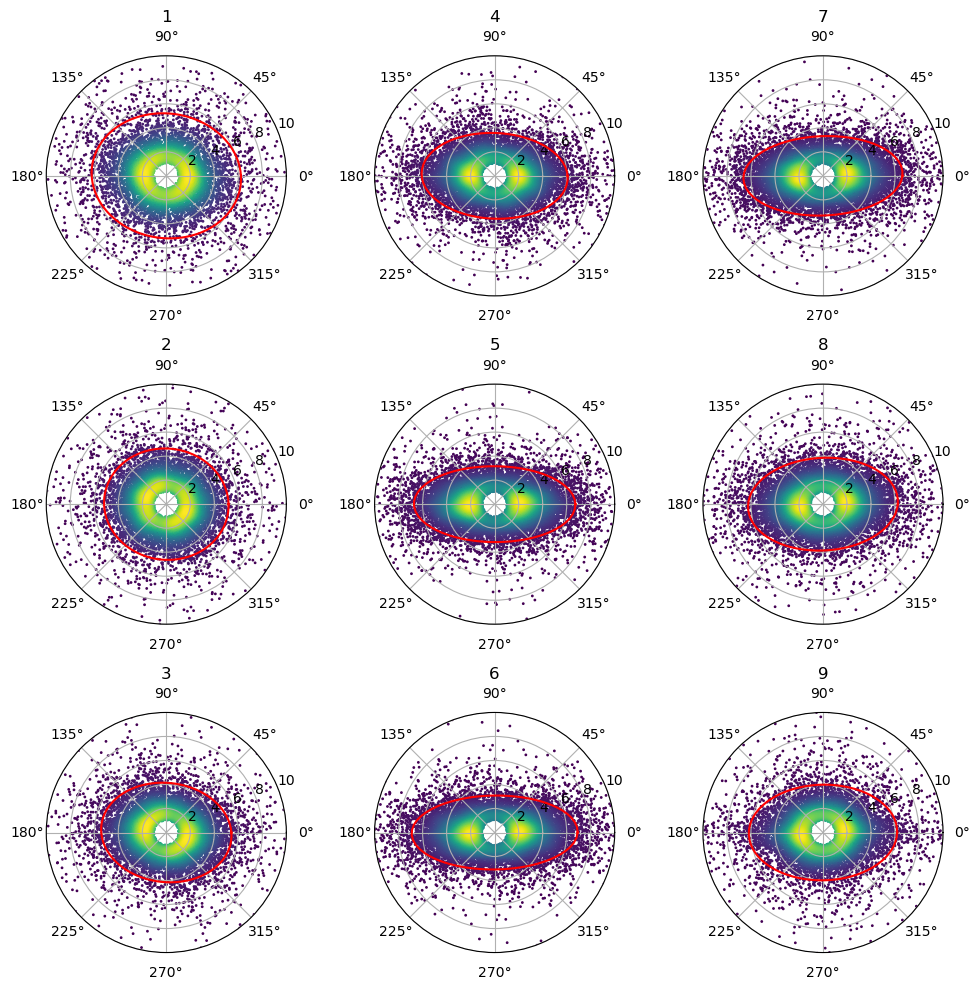

In [4]:
from fibrosisanalysis.plots.point_density import PointDensity
from fibrosisanalysis.analysis.structural_anisotrophy import (
    StruturalAnisotrophy
)
from fibrosisanalysis.analysis.distribution_ellipses import (
    DistributionEllipses
)


fig, axs = plt.subplots(3, 3, figsize=(10, 10), subplot_kw=dict(projection="polar"))
for pos in range(1, 10):
    i = pos - 1
    df = ddf[ddf['position'] == pos]

    r = df['axis_ratio'].values
    theta = df['theta'].values
    theta_range = np.linspace(0, 2 * np.pi, 100)
    n_std = 2

    r = np.concatenate((r, r))
    theta = np.concatenate((theta, theta + np.pi))
    r, theta, density = PointDensity.polar(r, theta)

    x, y = StruturalAnisotrophy.convert_to_cartesian(r, theta)
    dist_ellipses = DistributionEllipses('error')
    width, height, theta_ellipse = dist_ellipses.major_minor_axes(x, y, n_std)
    ellipse_radius = PointDensity.rotated_ellipse(0.5 * width, 0.5 * height, 
                                                  theta_range, theta_ellipse)
    
    ax = axs[i % 3, i // 3]
    ax.set_title(pos)
    ax.scatter(theta, r, c=density, s=1)
    ax.plot(theta_range, ellipse_radius, 
             label='{} (n_std={})'.format('error', n_std), color='red')
    ax.set_rmax(10)
plt.tight_layout()
plt.show()

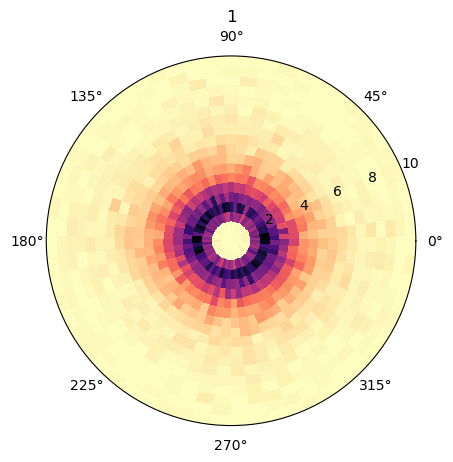

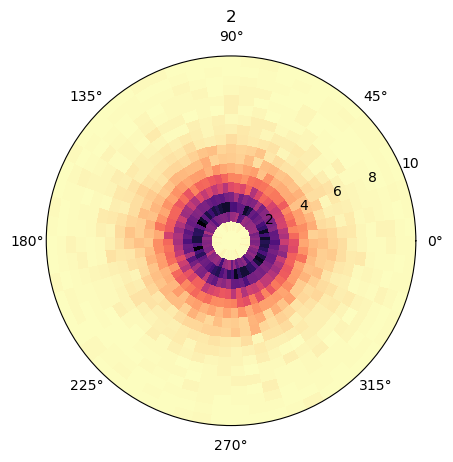

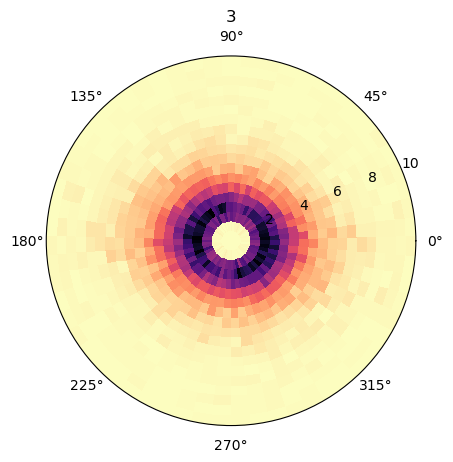

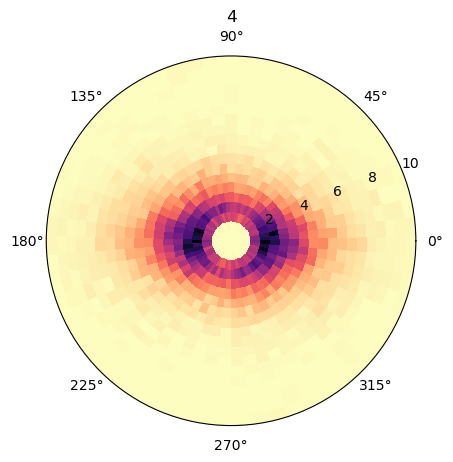

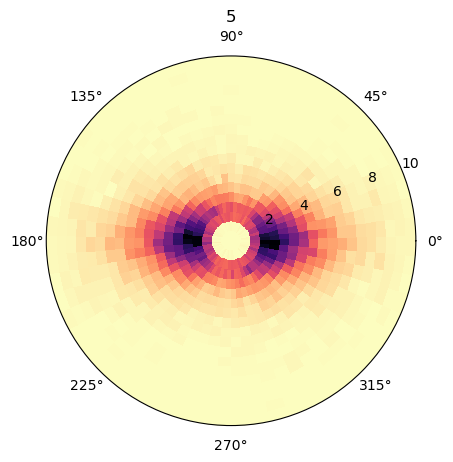

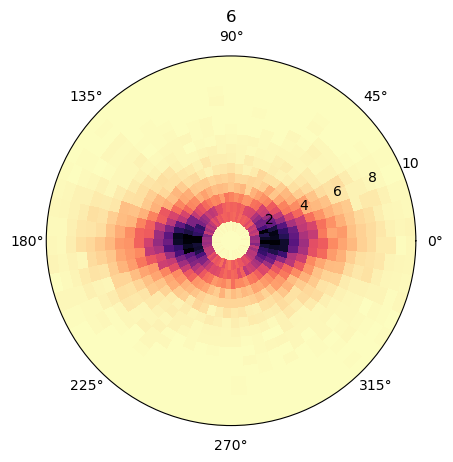

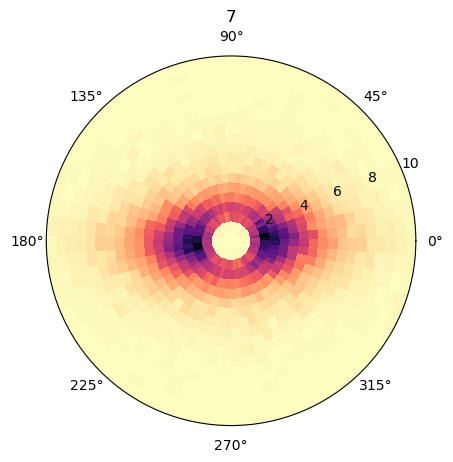

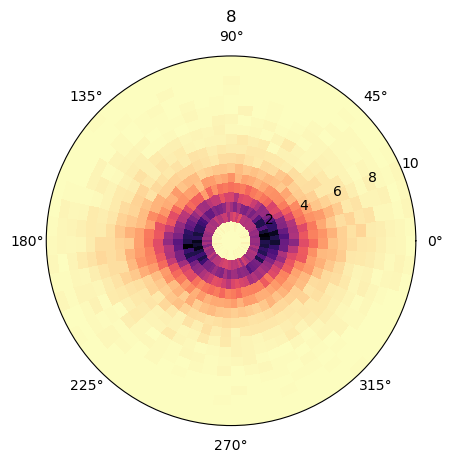

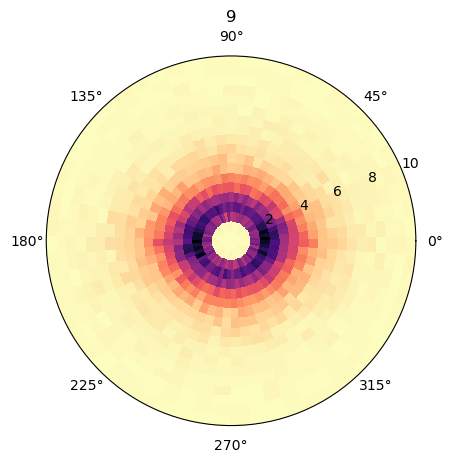

In [25]:
import matplotlib.pyplot as plt

# %matplotlib qt

rbins = np.linspace(0, 10, 20)
abins = np.linspace(-0.5*np.pi, 1.5*np.pi, 60)

# plot
# fig, axs = plt.subplots(ncols=3, nrows=3, subplot_kw=dict(projection="polar"))

for p in range(9):
    fig, axs = plt.subplots(subplot_kw=dict(projection="polar"))
    mask = df['position'] == p + 1
    r_ = df['axis_ratio'][mask].to_numpy()
    theta_ = df['theta'][mask].to_numpy()
    
    r = np.concatenate((r_, r_))
    theta = np.concatenate((theta_, theta_ + np.pi))
    
    hist, _, _ = np.histogram2d(theta, r, bins=(abins, rbins))
    A, R = np.meshgrid(abins, rbins)
    
    i = p // 3
    j = p % 3

    axs.grid(False)
    pc = axs.pcolormesh(A, R, hist.T, cmap="magma_r")
    axs.set_rmax(10)
    axs.set_title('{}'.format(p + 1))
    plt.show()

# plt.tight_layout()
# plt.show()

In [5]:
df = data[~data['image'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6408584 entries, 0 to 6408583
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   label              int64  
 1   centroid-0         float64
 2   centroid-1         float64
 3   major_axis_length  float64
 4   minor_axis_length  float64
 5   orientation        float64
 6   solidity           float64
 7   image              object 
 8   density            float64
 9   tangent            float64
 10  distance           float64
 11  area               int64  
 12  euler_number       int64  
 13  FileName           object 
 14  Heart              object 
 15  Unnamed: 0         float64
dtypes: float64(10), int64(3), object(3)
memory usage: 831.2+ MB


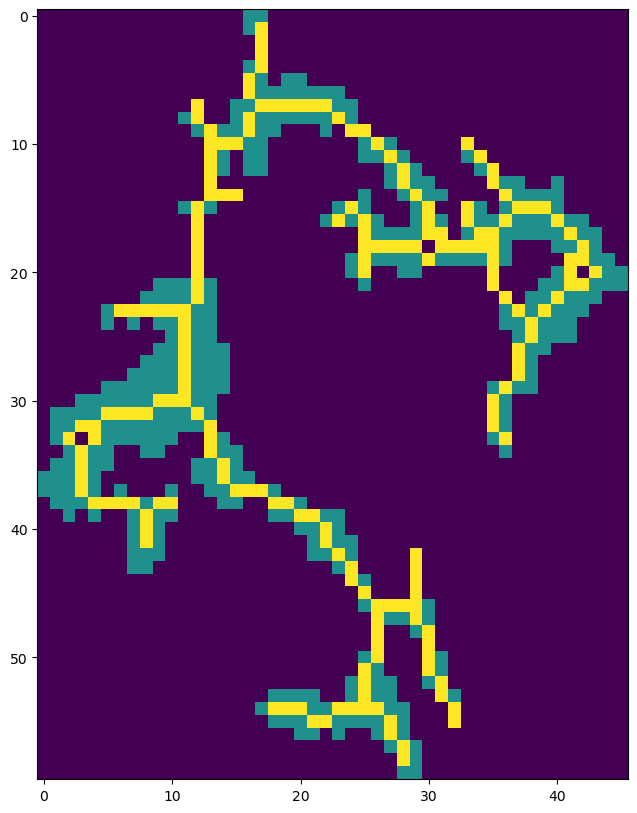

In [21]:
from skimage import morphology


df_100 = df[(df['area'] > 500) & (df['area'] < 600)]

image = df_100['image'].iloc[np.random.randint(0, len(df_100))]
skel = morphology.skeletonize(image)

plt.figure(figsize=(10, 10))
plt.imshow(image.astype(int) + skel.astype(int), cmap='viridis')
plt.show()

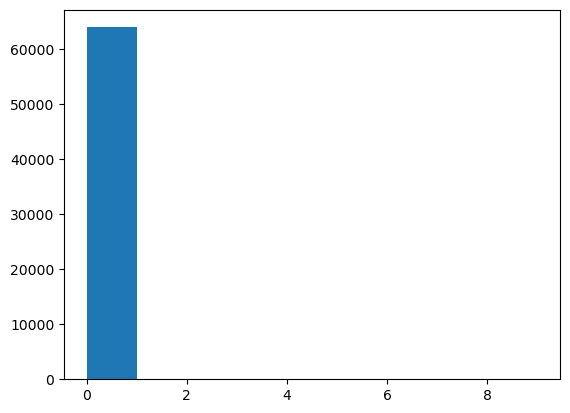

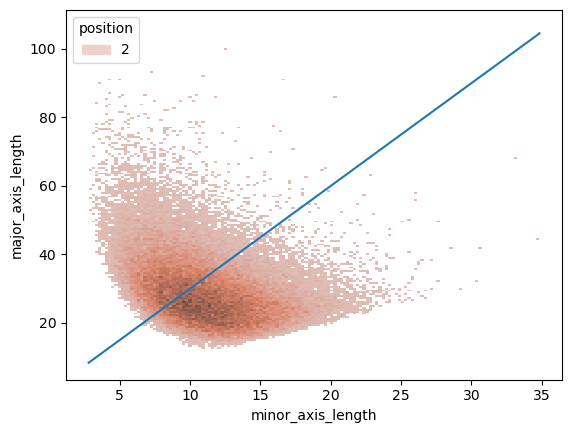

In [8]:
df['position'] = np.digitize(df['area'], np.linspace(10, 20, 2))

x = df['minor_axis_length']
y = df['major_axis_length']
h = df['position']

l = x / y
    
plt.figure()
plt.hist(l, bins=np.arange(0, 10))
plt.show()
    
plt.figure()

sns.histplot(x=x, y=y, hue=h)

x = np.linspace(x.min(), x.max(), 100)
y = 3 * x
plt.plot(x, y)
# plt.xlim([0, 120])
# plt.ylim([0, 120])
plt.show()